#Analyzing Temperature Anomaly Trends & Spatiotemporal Variabilities with Berkeley Earth and NASA GISTEMP Data
#### GR6901: Research Computing in Earth Science 
#### Tehreem Qureshi (UNI: tq2150)
#### 12/05/2024

### Introduction/Motivation:

#### Temperature anomaly datasets are important in analyzing past and future changes in temperature, and particularly when communicating analysis on anthropogenic climate change and warming. Particularly, 2023 was characterized as the warmest year on record, with 2024 'almost  certain'  to be the warmest year by the end (Berkeley Earth). Temperature anomaly datasets can vary based on resolution, time intervals, instrumentation and data processing used, and climatology, which may not produce very different results when analyzing global averages or long-term time averages, but may show differences on a shorter timescale and the regional level. This project aims to analyze temperature anomalies from instrumental records using the Berkeley Earth dataset and NASA's GISTEMP dataset. Through data processing and analyis, I analyze global yearly averages, warming trends on varying timescales, and gridded trends and anomalies. The project begins with the larger scope of the instrumental records (1850-2024 for Berkeley Earth and 1880-2024 for NASA GISTEMP) and narrows down to identifying a spatial region that may see anomaly discrepancies for the years 2020-2024, to hone in on the most recent years and identify jumps in the anthropogenic signal. 

#### Given recent news articles of potentially accelerating warming trends and the record-breaking temperatures seen in 2023 and 2024, this project serves to analyze differences among global yearly means for the dataset, analyze long-term and four-year trends, and hone in on any regional discrepancies specifically in the trend from 2020-2024. 

### Research Questions: 
#### 1. When analyzing long-term global yearly temperature anomalies and trends, are there differences between the Berkeley Earth and NASA GISTEMP datasets?
#### 2. What short-term, linear trends are observed among the datasets in four-year intervals from 1880-2024?
#### 3. With a focus on the 2020-2024 trend with grid cells rather than a global average, are there any regional discrepancies, and what differences in anomalies may be causing this discrepancy?

### Hypothesis: I hypothesize global averages will be aligned among the datasets, with more variability on the short-term/regional scales, as well as an increased trend among the 2020-2024 interval as opposed to previous years due to the strong warming signal. I expect to see some regional variabilities (slight differences in magnitude) of the data trend from 2020-2024, but following the general sign of the trend among the two datasets.

#### Datasets: 
##### Berkeley Earth, Average Temperature with Air Temperatures at Sea Ice (1850-present; resolution 1 degree by 1 degree): https://berkeleyearth.org/data/
##### NASA GISTEMP, Land-Ocean Temperature Index, ERSSTv5, (1880-present; resolution 2 degree by 2 degree): https://data.giss.nasa.gov/gistemp/

In [17]:
import xarray as xr
import numpy as np 
import pandas as pd 
from scipy import signal
from scipy.signal import butter, filtfilt, sosfiltfilt
from scipy.stats import linregress
import cartopy.feature as cfeature  
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib as mpl
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

### Downloading Berkeley Earth Data 

In [18]:
berkeleydata = 'Land_and_Ocean_Alternate_LatLong1.nc'
ds = xr.open_dataset(berkeleydata) 
temp = ds['temperature'] 
monthly_temps = ds['temperature'] 
temp['year'] = np.floor(temp['time']).astype(int)
weights = np.cos(np.deg2rad(ds.latitude))
temp_w = temp * weights
bd_gb = temp_w.groupby('year') # bd refers to 'berkeley data' & groupby year to use yearly averages 
bd_monthly_temps_w = monthly_temps * weights 

### Downloading NASA GISTEMP Data 

In [19]:
gistemp = 'gistemp1200_GHCNv4_ERSSTv5.nc.gz'
data = xr.open_dataset(gistemp) 
temp_gistemp = data.tempanomaly
monthly_gistemps = data.tempanomaly
weights = np.cos(np.deg2rad(data.lat))
temp_gistemp_w = temp_gistemp * weights
gt_gb = temp_gistemp_w.groupby(data.time.dt.year) # gt refers to 'gistemp'
gt_gistemp_monthly_w= temp_gistemp * weights
datetime_gt = pd.to_datetime(gt_gb.map(np.mean).year.astype(str), format='%Y') #  converting to datetime for easier plotting 

### Applying Simple Linear Regression and 10-Year Smoothing to Yearly Global Temp Anomalies 

In [20]:
slope_bd, intercept_bd, r_bd, p_bd, se_bd = linregress(bd_gb.map(np.mean).year, bd_gb.map(np.mean)) # simple linear regression for unsmoothed data for linear warming trend
slope_gt, intercept_gt, r_gt, p_gt, se_gt = linregress(gt_gb.map(np.mean).year, gt_gb.map(np.mean))
lowpassyr = 10
sos = signal.butter(4, 1./lowpassyr,'low',output='sos') #butterworth filter to smooth data to smooth out natural variabilities among datasets
bd_lp_trend = sosfiltfilt(sos,bd_gb.map(np.mean))
gt_lp_trend = sosfiltfilt(sos,gt_gb.map(np.mean))

### Comparisons of Yearly Global Average Temperature Anomalies between Berkeley Earth and NASA GISTEMP

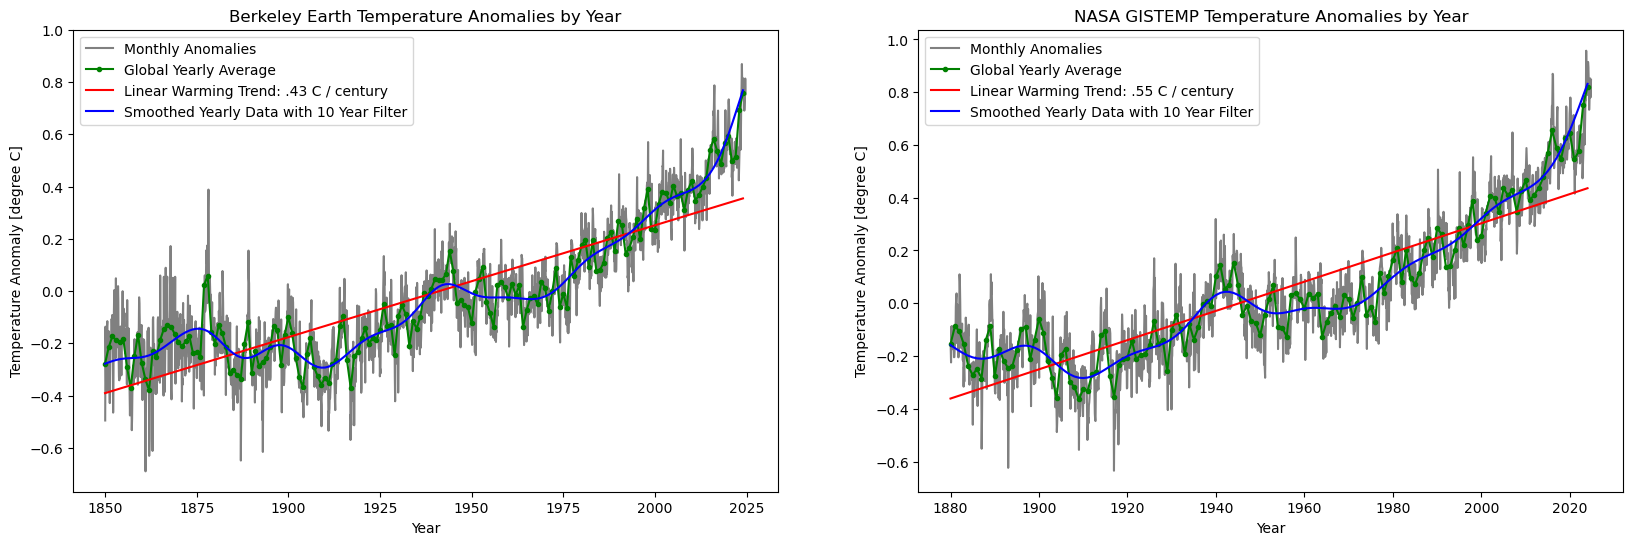

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
ax1 = axes[0]
ax2 = axes[1]
bd_monthly_temps_w.mean(dim=['latitude', 'longitude']).plot(ax=ax1, label = 'Monthly Anomalies', color = 'grey')
bd_gb.map(np.mean).plot(ax=ax1, label = 'Global Yearly Average', marker = 'o', markersize=3, color = 'green')
ax1.plot(bd_gb.map(np.mean).year, intercept_bd + bd_gb.map(np.mean).year*slope_bd, color = 'red', label = 'Linear Warming Trend: .43 C / century')
ax1.plot(bd_gb.map(np.mean).year, bd_lp_trend, color = 'blue', label = 'Smoothed Yearly Data with 10 Year Filter')
ax1.legend()
ax1.set_xlabel('Year')
ax1.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('Temperature Anomaly [degree C]')
ax1.set_title("Berkeley Earth Temperature Anomalies by Year")
gt_gistemp_monthly_w.mean(dim=['lat', 'lon']).plot(ax=ax2, label = 'Monthly Anomalies', color = 'grey')
ax2.plot(datetime_gt, gt_gb.map(np.mean), label = 'Global Yearly Average', marker = 'o', markersize=3, color = 'green')
ax2.plot(datetime_gt, intercept_gt+ gt_gb.map(np.mean).year*slope_gt, color = 'red', label = 'Linear Warming Trend: .55 C / century')
ax2.plot(datetime_gt, gt_lp_trend, color = 'blue', label = 'Smoothed Yearly Data with 10 Year Filter')
ax2.legend()
ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature Anomaly [degree C]')
ax2.set_title("NASA GISTEMP Temperature Anomalies by Year")
ax2.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.legend()
plt.show()

### Computing Four-Year Global Linear Warming Trends by Dataset

In [22]:
def compute_fouryeartrends(time_series): #defined function to go through each 5 year indices and average, append to pandas series
    trends = []
    grouped_years = []
    years = time_series.year
    iterations = years.size / 5
    indices = [0, 1, 2, 3, 4]
    for i in range(0, int(iterations)):
        y = time_series[indices]
        x = years[indices]
        slope, _, _, _, _ = linregress(x, y)
        trends.append(float(slope))
        grouped_years.append(str(years[indices[0]].values) + "-" + str(years[indices[4]].values))
        indices = [i + 5 for i in indices]
    return pd.Series(trends, index=grouped_years)

bd_4_years = compute_fouryeartrends(bd_gb.map(np.mean))
bd_4_years_subset = bd_4_years['1880-1884':]# to align with gistemp for analysis
gt_4_years = compute_fouryeartrends(gt_gb.map(np.mean))

four_year_df = pd.DataFrame({'Berkeley Earth': bd_4_years_subset, 'NASA GISTEMP': gt_4_years})
four_year_df.index.name = '4 Year Interval'

print(four_year_df) # putting both pandas series into a dataframe for direct comparison 

                 Berkeley Earth  NASA GISTEMP
4 Year Interval                              
1880-1884             -0.031191     -0.023628
1885-1889              0.048127      0.048230
1890-1894              0.006689      0.000611
1895-1899             -0.005680     -0.003817
1900-1904             -0.070985     -0.077266
1905-1909             -0.037960     -0.048030
1910-1914              0.048286      0.048153
1915-1919             -0.025947     -0.016656
1920-1924             -0.005723     -0.002779
1925-1929             -0.027561     -0.027239
1930-1934             -0.019375     -0.009869
1935-1939              0.038436      0.035713
1940-1944              0.024220      0.003189
1945-1949             -0.028580     -0.031262
1950-1954              0.025999      0.017691
1955-1959              0.036667      0.038228
1960-1964             -0.022828     -0.021669
1965-1969              0.019097      0.019203
1970-1974              0.001507      0.003958
1975-1979              0.038197   

### Individual Bar Plots of Global Linear Warming Trends For Four Year Intervals for Both Datasets

/tmp/ipykernel_1298/787680624.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/tmp/ipykernel_1298/787680624.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


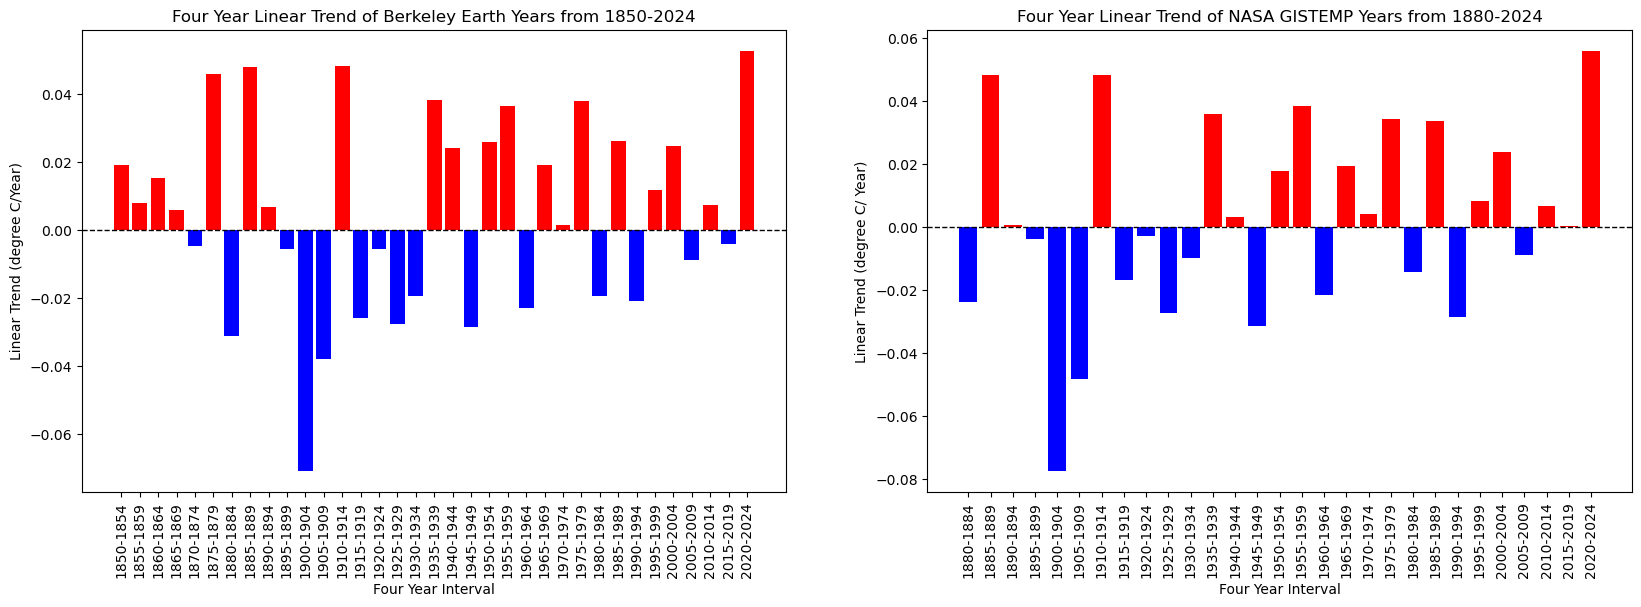

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
ax1 = axes[0]
ax2 = axes[1]
ax1.bar(bd_4_years.index, bd_4_years, color=['red' if value > 0 else 'blue' for value in bd_4_years]) # red if trend is positive, blue if negative 
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel('Four Year Interval')
ax1.set_ylabel('Linear Trend (degree C/Year)')
ax1.set_title('Four Year Linear Trend of Berkeley Earth Years from 1850-2024') # use full dataset for individual representation
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax2.bar(gt_4_years.index, gt_4_years, color=['red' if value > 0 else 'blue' for value in gt_4_years])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('Four Year Interval')
ax2.set_ylabel('Linear Trend (degree C/ Year)')
ax2.set_title('Four Year Linear Trend of NASA GISTEMP Years from 1880-2024')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)


### Direct Comparison of Global Four Year Linear Trends Using Line Plot

Text(0.5, 1.0, 'Comparison of Four Year Yearly Linear Trends from 1880-1850 with Berkeley Earth and NASA GISTEMP Datasets')

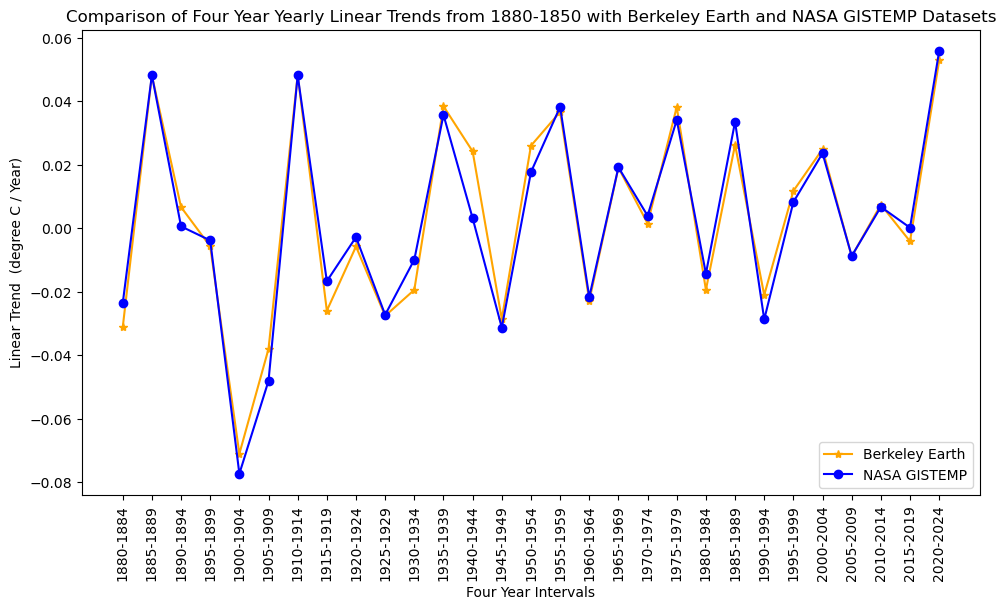

In [24]:
plt.figure(figsize=(10, 6)) 
plt.plot(bd_4_years_subset.index, bd_4_years_subset, label = 'Berkeley Earth', marker = '*', color = 'orange') #subset index to align timescales for dataest comparison
plt.plot(gt_4_years.index, gt_4_years, label = 'NASA GISTEMP', marker = 'o', color = 'blue')
plt.legend()
plt.ylabel('Linear Trend  (degree C / Year)')
plt.xlabel('Four Year Intervals')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Comparison of Four Year Yearly Linear Trends from 1880-1850 with Berkeley Earth and NASA GISTEMP Datasets')

### Calculating 2020-2024 Linear Trend by Grid Cell for Datasets

In [25]:
yearly_grid_avg_bd = bd_gb.mean() # call .mean() on dataset rather than .map(np.mean) to take mean among years but not lat/lon dimension
yearly_grid_avg_gt = gt_gb.mean()
years = yearly_grid_avg_gt[-5:].year # use last 5 years, corresponding to 2020-2024

def compute_slope(time_series):
    time = np.asarray(years)
    last_five = time_series[-5:]
    slope, intercept, r_value, p_value, std_err = linregress(time, last_five)
    return slope
    
linear_trend_bd = xr.apply_ufunc( # this function is applied to each lat/lon cell and computes the function across year dimension
    compute_slope,  
    yearly_grid_avg_bd,     
    input_core_dims=[['year']],  
    output_core_dims=[[]],   
    vectorize=True,              
    dask='allowed',             
)

linear_trend_gt = xr.apply_ufunc(
    compute_slope,  
    yearly_grid_avg_gt,     
    input_core_dims=[['year']],  
    output_core_dims=[[]],   
    vectorize=True,              
    dask='allowed',             
)

### Plotting Grid Cell 2020-2024 Warming Trends for Each Dataset & Analyze Discrepancy in Southwest Africa (Black Box)

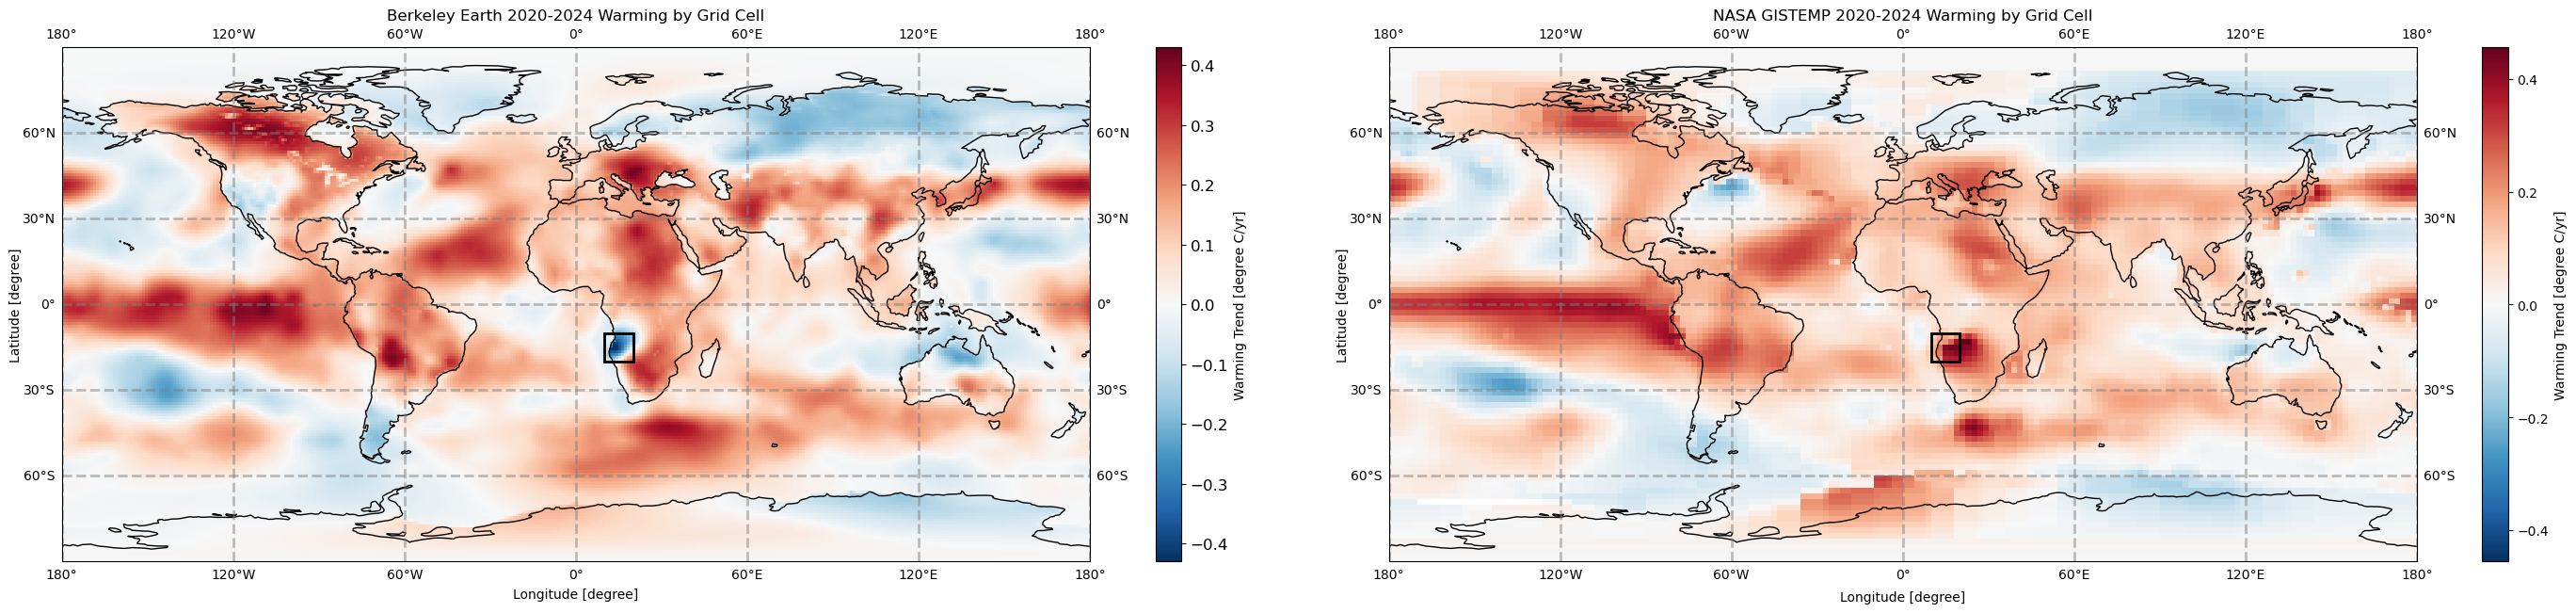

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})
linear_trend_bd.plot(ax=axes[0], cmap=plt.cm.RdBu_r)
ax=axes[0]
axes[0].coastlines()
axes[0].set_title('Berkeley Earth 2020-2024 Warming by Grid Cell')
axes[0].set_yticks([]) # this manually adds y ticks to be able to add labels on next line
axes[0].set_ylabel('Latitude [degree]', labelpad=30)
axes[0].set_xticks([]) 
axes[0].set_xlabel('Longitude [degree]', labelpad=20)
axes[0].set_global()  
colorbar = ax.collections[0].colorbar
colorbar.set_label('Warming Trend [degree C/yr]', fontsize=10) 
fig.subplots_adjust(right=1.5, left=0.4) 
colorbar.ax.tick_params(labelsize=12)
axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
linear_trend_gt.plot(ax=axes[1], cmap=plt.cm.RdBu_r)
ax=axes[1]
axes[1].set_title('NASA GISTEMP 2020-2024 Warming by Grid Cell')
colorbar = ax.collections[0].colorbar
colorbar.set_label('Warming Trend [degree C/yr]', fontsize=10) 
axes[1].set_ylabel('Latitude [degree]')
axes[1].set_xlabel('Longitude [degree]')
axes[1].coastlines()
axes[1].set_global()  
axes[1].set_yticks([]) 
axes[1].set_ylabel('Latitude [degree]', labelpad=30)
axes[1].set_xticks([]) 
axes[1].set_xlabel('Longitude [degree]', labelpad=22)
axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
longitude = slice(10, 20) # identify general area of boxes where we see a difference of lat and lon and plot them on graph
latitude = slice(-20, -10)
lon, lat, width, height =  (10, -20, 10, 10) 
rect1 = mpatches.Rectangle((lon, lat), width, height,
                           linewidth=2, edgecolor='black', facecolor='none',
                           transform=ccrs.PlateCarree())
rect2 = mpatches.Rectangle((lon, lat), width, height,
                           linewidth=2, edgecolor='black', facecolor='none',
                           transform=ccrs.PlateCarree())
axes[0].add_patch(rect1)
axes[1].add_patch(rect2)
plt.tight_layout()
fig.subplots_adjust(right=1.6, left=.2) # fixing formatting

### Visualizing the Grid Cell Temperature Anomaly for Both Datasets by Year in Southwest Africa

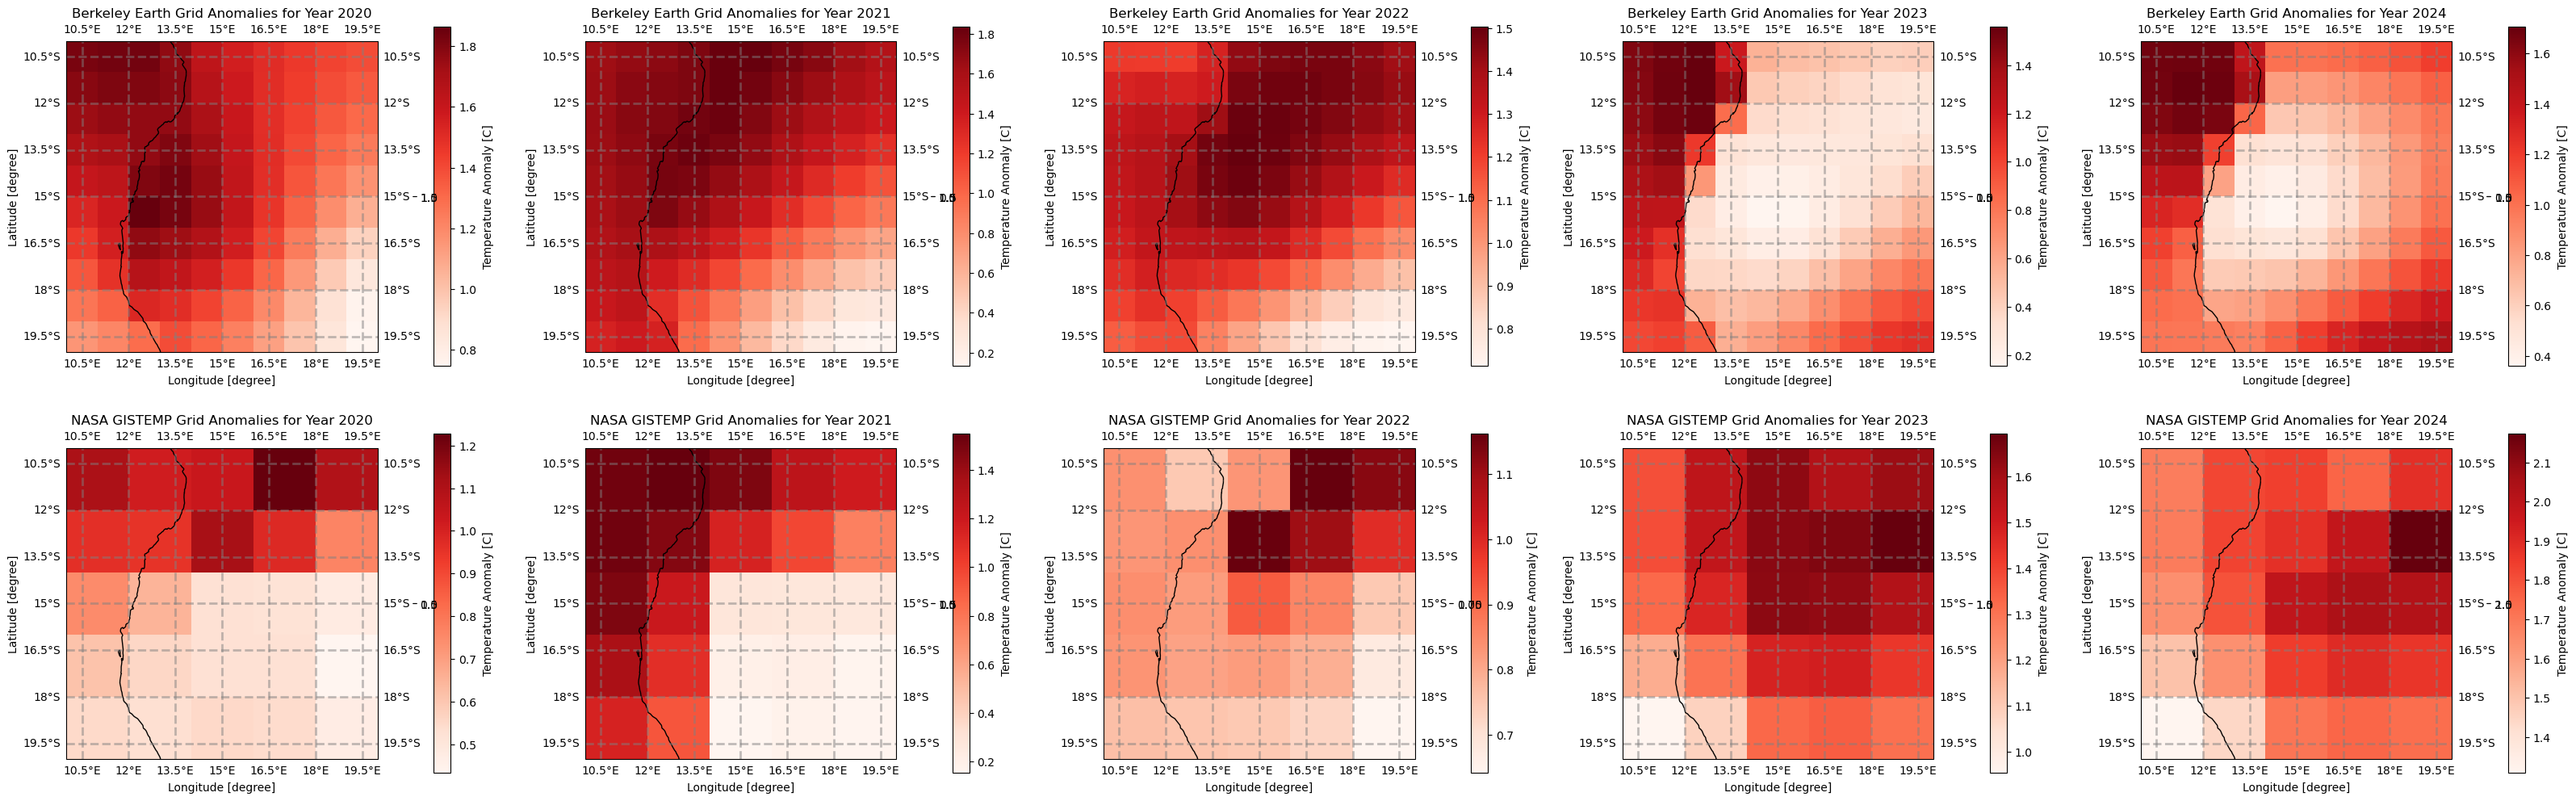

In [27]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
bd_gb.mean().sel(year=2020).sel(latitude=latitude, longitude=longitude).plot(ax=axes[0], cmap='Reds')
bd_gb.mean().sel(year=2021).sel(latitude=latitude, longitude=longitude).plot(ax=axes[1], cmap='Reds')
bd_gb.mean().sel(year=2022).sel(latitude=latitude, longitude=longitude).plot(ax=axes[2], cmap='Reds')
bd_gb.mean().sel(year=2023).sel(latitude=latitude, longitude=longitude).plot(ax=axes[3],cmap='Reds')
bd_gb.mean().sel(year=2024).sel(latitude=latitude, longitude=longitude).plot(ax=axes[4], cmap='Reds')
gt_gb.mean().sel(year=2020).sel(lat=latitude, lon=longitude).plot(ax=axes[5], cmap='Reds')
gt_gb.mean().sel(year=2021).sel(lat=latitude, lon=longitude).plot(ax=axes[6], cmap='Reds')
gt_gb.mean().sel(year=2022).sel(lat=latitude, lon=longitude).plot(ax=axes[7], cmap='Reds')
gt_gb.mean().sel(year=2023).sel(lat=latitude, lon=longitude).plot(ax=axes[8], cmap='Reds')
gt_gb.mean().sel(year=2024).sel(lat=latitude, lon=longitude).plot(ax=axes[9],cmap='Reds')

for i in range(0, 10):
    axes[i].coastlines()
    axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--') 
    axes[i].set_yticks([]) # this manually adds y ticks to be able to add labels on next line
    axes[i].set_ylabel('Latitude [degree]', labelpad=42)
    if i==0:
        axes[i].set_title('Berkeley Earth Grid Anomalies for Year 2020')
    if i==1: 
        axes[i].set_title('Berkeley Earth Grid Anomalies for Year 2021')
    if i==2: 
        axes[i].set_title('Berkeley Earth Grid Anomalies for Year 2022')
    if i==3: 
        axes[i].set_title('Berkeley Earth Grid Anomalies for Year 2023')
    if i==4: 
        axes[i].set_title('Berkeley Earth Grid Anomalies for Year 2024')
    if i==5: 
        axes[i].set_title('NASA GISTEMP Grid Anomalies for Year 2020')
    if i==6: 
        axes[i].set_title('NASA GISTEMP Grid Anomalies for Year 2021')
    if i==7: 
        axes[i].set_title('NASA GISTEMP Grid Anomalies for Year 2022')
    if i==8: 
        axes[i].set_title('NASA GISTEMP Grid Anomalies for Year 2023')
    if i==9: 
        axes[i].set_title('NASA GISTEMP Grid Anomalies for Year 2024')
    axes[i].set_xticks([]) 
    axes[i].set_xlabel('Longitude [degree]', labelpad=20)
    cbar = fig.colorbar(axes[i].collections[0], fraction=0, pad=0.1)
    cbar.set_label('Temperature Anomaly [C]', fontsize=10, labelpad=40)

fig.subplots_adjust(right=1.85)

### Conclusions: 

#### 1. The analysis shows that there are not significant differences among the global values average anomalies, although there is a slight difference in the linear trend of warming (.43 C/century versus .55 C/century) using the entire record, though this is expected due to potential missing NaN values in the data and different time scales. 
#### 2. There is consistency among the global linear trends of four year intervals and specifically, consistency in 2020-2024 at about .05 C/year (note the jump in this short-term trend when compared to the long-term warming above!). It is important to note that this does not indicate a strong warming or cooling trend due to its short interval, but more so compares if subsequent years in a group were warmer than previous and short-term jumps in temperature. 
#### 3. An interesting result from this analysis reveals that on a global grid-by-grid analysis for the 2020-2024 linear trend, there is a region of Southwest Africa in which Berkeley Earth sees a negative trend and NASA GISTEMP sees a positive trend (otherwise, despite slight differences in resolutino, the grid by grid analysis reveals that the 2020-2024 trends among regions are similar for both datasets). With a focus on this Southwest African region, yearly anomaly grid analysis for this box from 2020 to 2024 shows that for Berkeley Earth, grid cells see lower anomalies as the years progress. NASA GISTEMP sees higher anomalies for grids, which is the reason for the positive trend. Note, while the anomalies may be decreasing for some grid cells, both datasets still see all positive anomalies. 

####  My hypothesis for this project was mainly supported in global anomaly alignment between datasets, although there was an unexpected negative versus positive trend in the dataset for the Southwest African region among the 2020-2024 data. This may indicate some variabilities present given short term and regional focus. Further research could be conducted to see if there were any particularly interesting temperature/climate trends observed in Southwest Africa (or countries within it) for this time period that may have caused datasets to differ, although preliminary literature reviews/online do not show much evidence for this. 